# Données "syndromes grippaux"

# 1)
Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth.fr/ias pour plus d’information sur les données. Affichez les 5 premières lignes du jeu de données. On va travailler seulement avec la variable IAS_brut, sous la forme d’une série temporelle, dont on précisera la fréquence d’échantillonage et les dates de début et de fin. Pour cette variable, dans ce jeu de données, les cas de nullité correspondent à des données manquantes. Combien de données manquantes comporte-t-elle ? Pour les traitements des questions suivantes, éliminez les données manquantes par imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non-observées à partir des valeurs aux dates observées : par exemple par la moyenne de deux dates les
plus proches.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
from scipy import stats
import statsmodels.graphics.tsaplots as tsa

In [2]:
data = pd.read_csv("OpenhealthS-Grippal.csv",delimiter=";")

In [3]:
data[0:5]

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,"1,7","2,2","2,3"
1,2009-07-02,"3,4","2,1","2,3"
2,2009-07-03,"2,1","2,1","2,3"
3,2009-07-04,"1,3",2,"2,3"
4,2009-07-05,"14,2",2,"2,3"


La fréquence d'échantillonage est journalière.

In [4]:
print("La date de début d'échantillonage est {}.".format(data["PERIODE"][0]))
print("La date de fin d'échantillonage est {}.".format(data["PERIODE"][len(data)-1]))

La date de début d'échantillonage est 2009-07-01.
La date de fin d'échantillonage est 2014-04-17.


In [5]:
print("Le nombre de valeurs manquantes est {}.".format(data['IAS_brut'][data['IAS_brut']=="0"].count()))

Le nombre de valeurs manquantes est 8.


In [6]:
data['IAS_brut']=data['IAS_brut'].replace(',','.',regex=True)

In [7]:
data['IAS_brut']=data['IAS_brut'].astype(float)

In [8]:
data['IAS_brut']=data['IAS_brut'].replace(0.0, np.nan)

In [9]:
data['IAS_brut'].isnull().sum() # on vérifie qu'on a bien le même nombre de valeurs manquantes

8

In [10]:
data['IAS_brut']=data['IAS_brut'].interpolate()

In [11]:
data['IAS_brut'].isnull().sum() # on vérifie qu'on n'a plus de valeur manquante

0

# 2)
Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous
observez.

/home/savoga/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


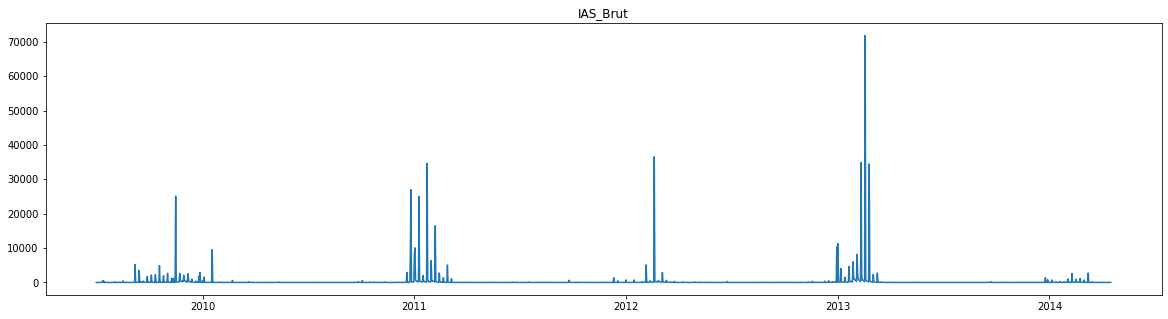

In [12]:
plt.figure(figsize=(20,5))
data['PERIODE'] = pd.to_datetime(data['PERIODE'])
plt.plot(data['PERIODE'].values, data['IAS_brut'].values)
plt.title("IAS_Brut")
plt.show()

"Le modèle utilisé pour l’IAS® Syndromes grippaux est basé sur le suivi d’un ensemble de médicaments prescrits en cas de suspicion de grippe saisonnière en France et utilise les méthodes d’analyse et de représentations développées par OpenHealth."

On remarque que le niveau de grippe est saisonnier et qu'il est surtout fort en fin/début d'année (période d'hiver).

# 3)
Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme a sur la trajectoire représentée à la question précédente?

(array([1.736e+03, 7.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.000000e-01, 7.185270e+03, 1.437044e+04, 2.155561e+04,
        2.874078e+04, 3.592595e+04, 4.311112e+04, 5.029629e+04,
        5.748146e+04, 6.466663e+04, 7.185180e+04]),
 <a list of 10 Patch objects>)

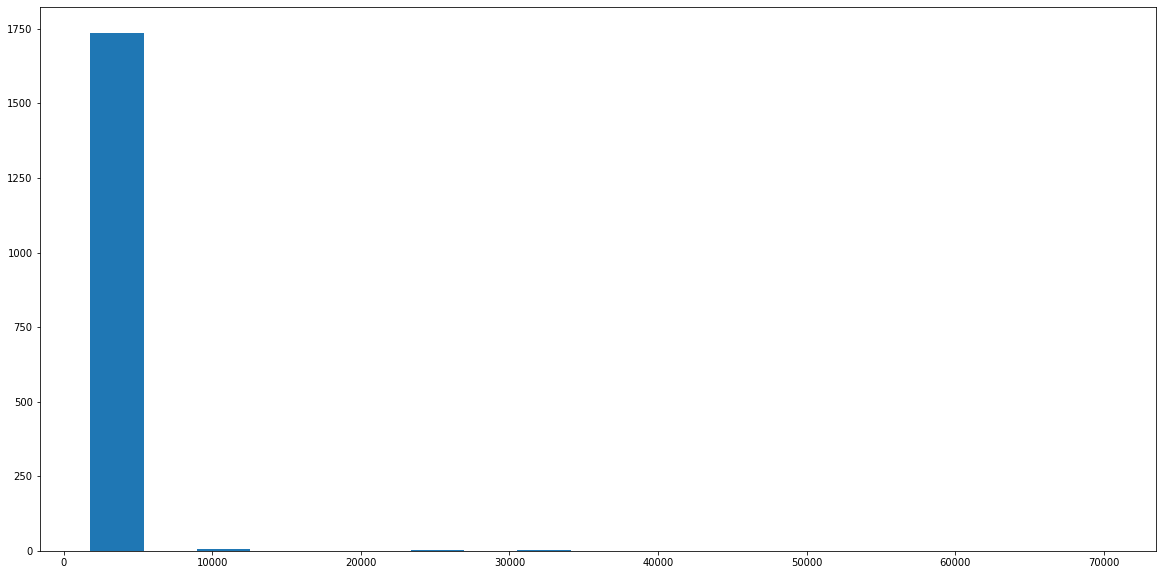

In [13]:
plt.figure(figsize=(20,10))
plt.hist(data['IAS_brut'], rwidth=0.5)

On remarque qu'une faible proportion des données sont très élevées (>10000), mais suffisament pour s'assurer qu'il ne s'agit pas de valeurs aberrantes. Ceci a pour effet d'aplatir fortement la proportion des valeurs faibles.

# 4)
Reprenez les questions précédentes après tranformations des observations par le logarithme naturel. Commentez.

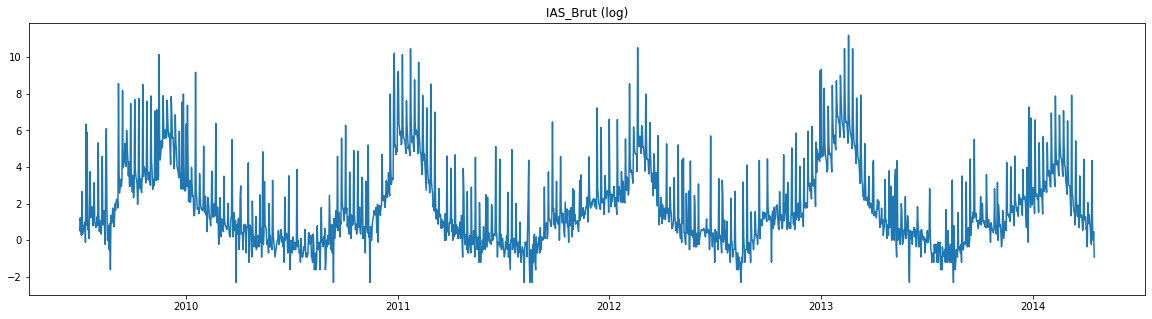

In [14]:
plt.figure(figsize=(20,5))
data['PERIODE'] = pd.to_datetime(data['PERIODE'])
plt.plot(data['PERIODE'].values, np.log(data['IAS_brut'].values))
plt.title("IAS_Brut (log)")
plt.show()

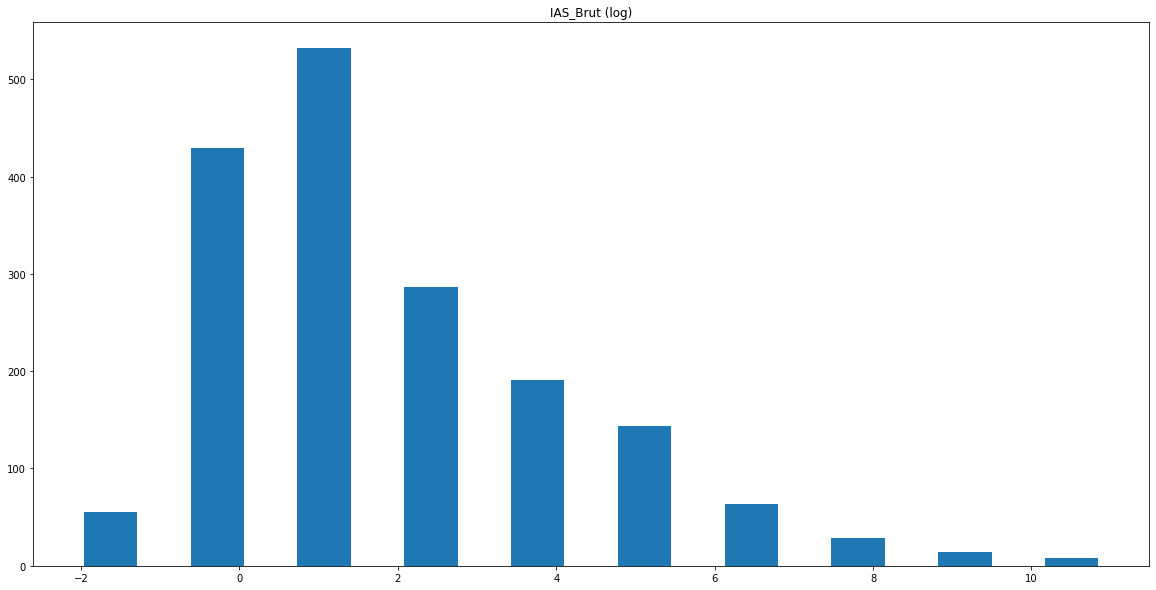

In [15]:
plt.figure(figsize=(20,10))
plt.hist(np.log(data['IAS_brut']), rwidth=0.5)
plt.title("IAS_Brut (log)")
plt.show()

La transformée logarithmique donne des résultats plus explicites.

"Le logarithme a pour effet de pénaliser les riches et de favoriser les pauvres."

Cependant, les valeurs très faibles (en dessous de zéro) apparaissent maintenant négatives.

On utilisera la transformation logarithmique pour la suite du devoir.

In [16]:
data['IAS_log'] = np.log(data['IAS_brut'])

# 5)
En utilisant signal.periodogram() (du package signal importé depuis scipy), tracez le périodogramme des données. Expliquez les pics les plus significatifs que vous observez. Attention au fait que dans la communauté signal les spectres sont normalisées pour des fréquences absolues dans $[-1/2,1/2]$ plutôt que $[-\pi,\pi]$.

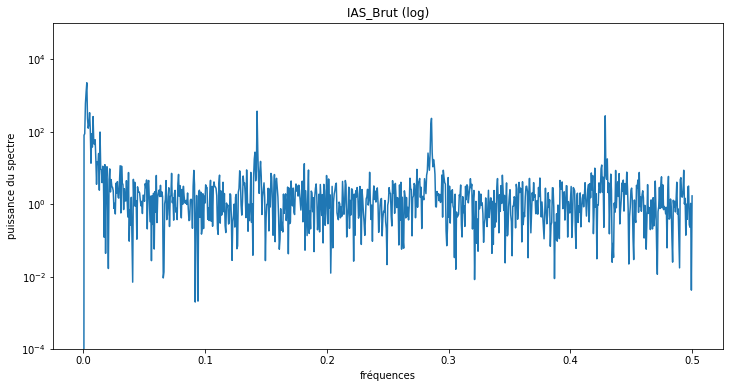

In [17]:
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(data['IAS_log'])
plt.semilogy(f, Pxx_den)
plt.ylim([10e-5, 10e+4])
plt.title("IAS_Brut (log)")
plt.xlabel("fréquences")
plt.ylabel("puissance du spectre")
plt.show()

<u>Interprétation</u>: les pics se situent sur les fréquences pour lesquelles la périodicité est forte. (à confirmer)

# 6)
Pour supprimer une tendance périodique de période $T$ dans un signal $(x_t)_{t \in \mathbb{Z}}$ il suffit d’appliquer le filtre $\Delta_T$ défini par:

$$[\Delta_Tx]_t = x_t − x_{t−T}$$

Utilisez cette méthode pour supprimer la tendance périodique de période 1 an. Quel pic du périodogramme cette méthode a fait disparaître ?

In [18]:
filteredIAS = []
for i in range(365,data.shape[0]):
    filteredIAS.append(data['IAS_log'].iloc[i] - data['IAS_log'].iloc[i-365])

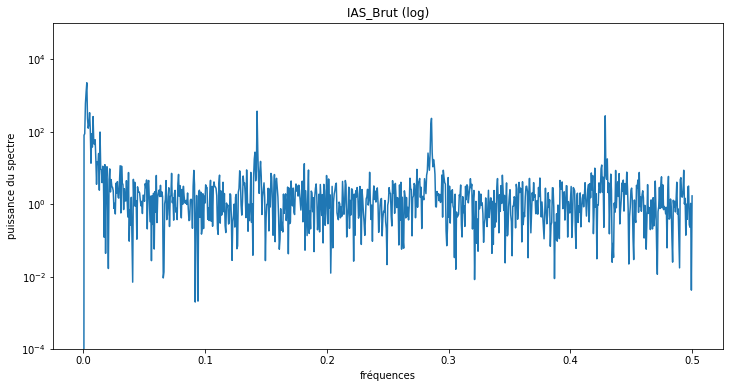

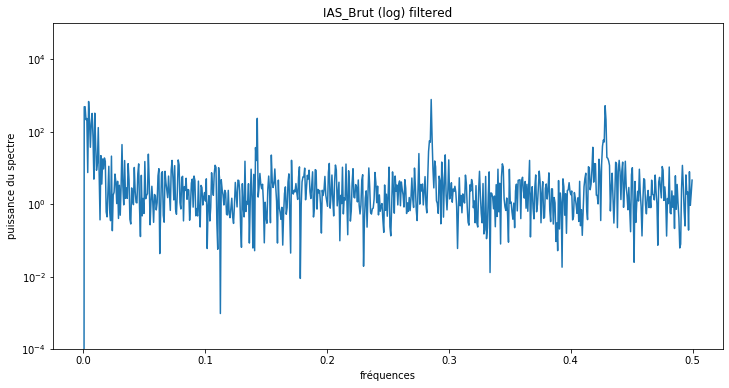

In [19]:
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(data['IAS_log'])
plt.semilogy(f, Pxx_den)
plt.ylim([10e-5, 10e+4])
plt.title("IAS_Brut (log)")
plt.xlabel("fréquences")
plt.ylabel("puissance du spectre")
plt.show()
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(filteredIAS)
plt.semilogy(f, Pxx_den)
plt.ylim([10e-5, 10e+4])
plt.title("IAS_Brut (log) filtered")
plt.xlabel("fréquences")
plt.ylabel("puissance du spectre")
plt.show()

On note que certains pics ont été réduits, notamment le premier et dernier.

### 7) 
On vous propose un exercise de prédiction uniquement à partir de la tendance périodique. On va prédire les valeurs de IAS_brut pour les dates du 1er avril 2013 au 17 avril 2014 en se basant sur les observations précédentes (du 1er juillet 2009 au 31 mars 2013) pour estimer la tendance périodique des données. Pour cela, pour un nombre d’harmoniques fixé (disons n_harm), construisez les variables explicatives pour la période d’apprentissage : pour chaque k = 1, 2, ... n_harm, ajoutez deux variables explicatives, $x_{i,2k−1} = cos(t_i·k·\frac{2 \pi}{T})$ et $x_{i,2k} = sin(t_i·k·\frac{2 \pi}{T})$, où $t_i$ est le moment de temps (on peut utiliser les nombres entiers au lieu de dates) et T = 365. Estimez la tendance périodique en régressant les données d’apprentissage sur ces variables explicatives. Avec ce modèle linéaire, prédisez les valeurs du variable IAS_brut pour la période du 1er avril 2013
au 17 avril 2014.


Tracez les valeurs de la série temporelle et votre prédiction pour l’ensemble de données (vous pouvez utilisez les couleurs différentes pour les parties apprentissage et prédiction). Puis, donnez le risque quadratique de la prédiction et tracez les résidus pour la période prédite. Essayez les valeurs de n_harm pour voir comment varie le risque quadratique de la prédiction.

##### Test avec n_harm = 10

In [20]:
data_reg = data.copy()

In [21]:
n_harm = 10
col_select = []
for k in range(1,n_harm+1):
    data_reg['add' + str(k)] = np.cos(data_reg.index*k*2*math.pi / 365) + np.sin(data_reg.index*k*2*math.pi / 365)
    col_select.append('add' + str(k))

In [22]:
data_train = data_reg[data_reg['PERIODE'] < '2013-03-31']
data_test = data_reg[data_reg['PERIODE'] >= '2013-03-31']

In [23]:
X_train = data_train[col_select]
Y_train = data_train['IAS_brut']
X_test = data_test[col_select]

In [24]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
coef_ = lr.fit(X_train,Y_train)
Y_pred = coef_.predict(X_test)

In [25]:
Y_test = data_test['IAS_brut']

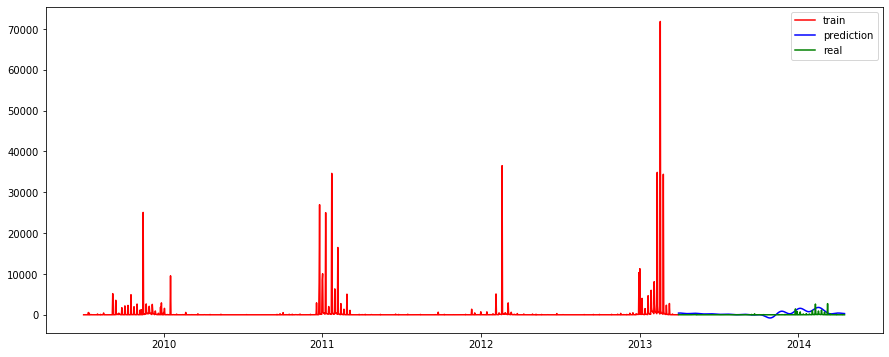

In [27]:
plt.figure(figsize=(15,6))
plt.plot(data_train['PERIODE'],Y_train,'r', label='train')
plt.plot(data_test['PERIODE'],Y_pred,'b',label='prediction')
plt.plot(data_test['PERIODE'],Y_test,'g',label='real')
plt.legend()
plt.show()

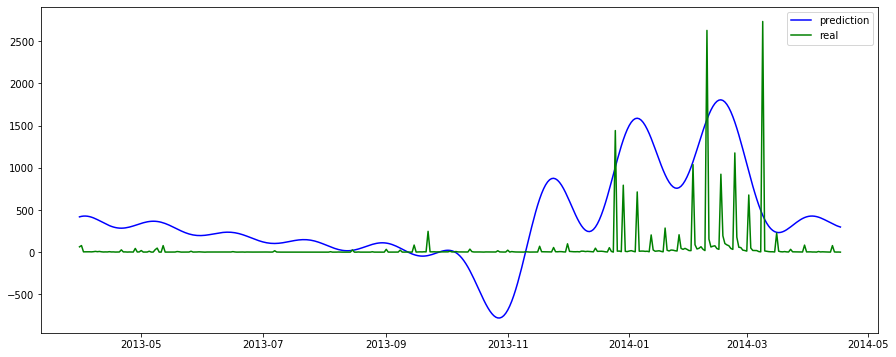

In [28]:
plt.figure(figsize=(15,6))
plt.plot(data_test['PERIODE'],Y_pred,'b',label='prediction')
plt.plot(data_test['PERIODE'],Y_test,'g',label='real')
plt.legend()
plt.show()

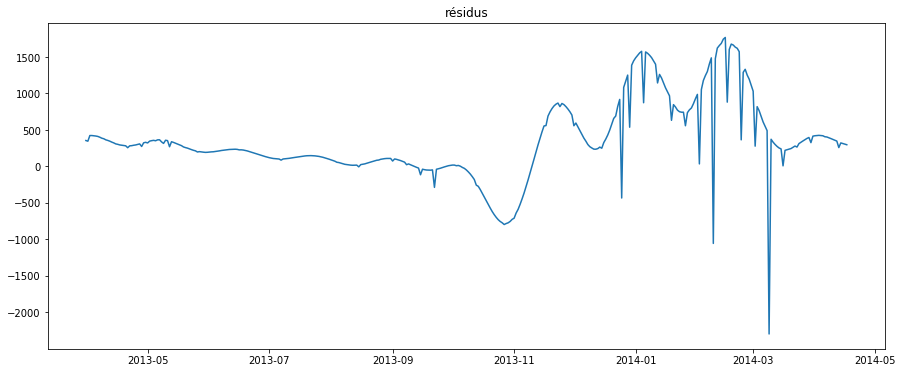

In [29]:
plt.figure(figsize=(15,6))
plt.plot(data_test['PERIODE'],Y_pred-Y_test)
plt.title('résidus')
plt.show()

In [31]:
print(1/len(Y_test)*np.sum((Y_pred-Y_test)**2))

386651.04393218586


##### Test avec n_harm = 5

In [32]:
data_reg = data.copy()
n_harm = 5
col_select = []
for k in range(1,n_harm+1):
    data_reg['add' + str(k)] = np.cos(data_reg.index*k*2*math.pi / 365) + np.sin(data_reg.index*k*2*math.pi / 365)
    col_select.append('add' + str(k))
data_train = data_reg[data_reg['PERIODE'] < '2013-03-31']
data_test = data_reg[data_reg['PERIODE'] >= '2013-03-31']
X_train = data_train[col_select]
Y_train = data_train['IAS_brut']
X_test = data_test[col_select]
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
coef_ = lr.fit(X_train,Y_train)
Y_pred = coef_.predict(X_test)
Y_test = data_test['IAS_brut']

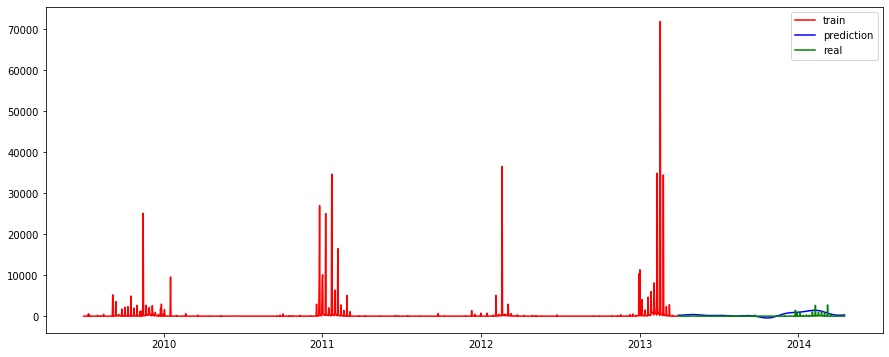

In [34]:
plt.figure(figsize=(15,6))
plt.plot(data_train['PERIODE'],Y_train,'r', label='train')
plt.plot(data_test['PERIODE'],Y_pred,'b',label='prediction')
plt.plot(data_test['PERIODE'],Y_test,'g',label='real')
plt.legend()
plt.show()

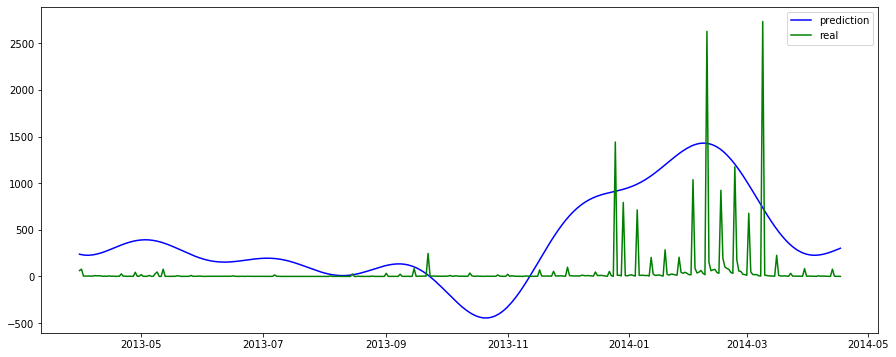

In [35]:
plt.figure(figsize=(15,6))
plt.plot(data_test['PERIODE'],Y_pred,'b',label='prediction')
plt.plot(data_test['PERIODE'],Y_test,'g',label='real')
plt.legend()
plt.show()

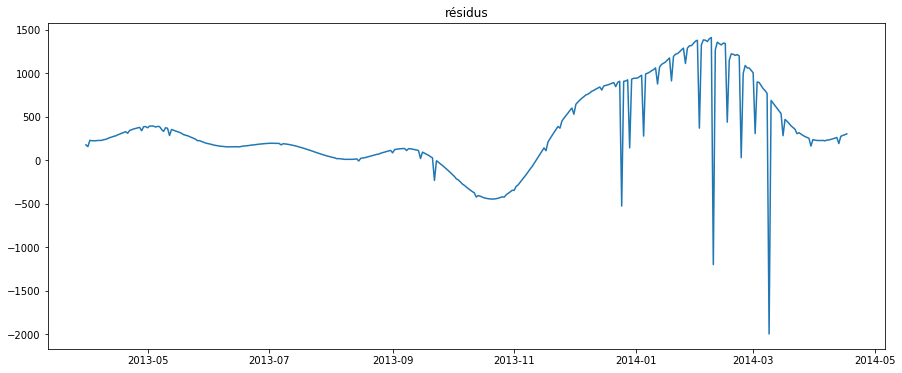

In [36]:
plt.figure(figsize=(15,6))
plt.plot(data_test['PERIODE'],Y_pred-Y_test)
plt.title('résidus')
plt.show()

In [37]:
print(1/len(Y_test)*np.sum((Y_pred-Y_test)**2))

332298.97419829667


On remarque que le risque quadratique est inférieur avec un nombre d'harmonique plus faible. On peut justifier cela par le fait qu'avec un nombre d'harmoniques trop élevé, le bruit apparaît aussi dans les prédictions (surapprentissage).

# Données "trafic internet"

# 1)

Importez les données du fichier lbl-tcp-3.tcp. Chaque ligne du tableau correspond à un paquet et la première variable et le moment de sa transmission ; consultez ftp://ita.ee.lbl.gov/html/contrib/LBL-TCP-3.html pour plus d’information sur les données. Affichez 5 premières lignes du jeu de données.
Tout d’abord, créez la série temporelle, où chaque observation correspond au nombre de paquets transmis dans un intervalle de 10 secondes. Il y a 720 intervalles, donc vous devez obtenir 720 observations.
Tracez la série temporelle obtenue.

In [38]:
data = pd.read_csv("lbl-tcp-3.tcp",delimiter=" ", names = ["timestamp", "sourceHost", "destinationHost", "sourceTCPPort", "destinationTCPPort", "bytes"])

In [39]:
data[0:5]

,timestamp,sourceHost,destinationHost,sourceTCPPort,destinationTCPPort,bytes
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


In [40]:
data['time_intervalle'] = data['timestamp'].map(lambda x : datetime.timedelta(x))

In [41]:
data.at[0, 'time_intervalle'] = 0

In [42]:
data['time_intervalle'] = data['time_intervalle']/86400

In [43]:
bytes_cum_array = []
bytes_cum=0
for index in range(1, len(data)-1) :
    time_cum = data.loc[index, 'time_intervalle'].total_seconds() - len(bytes_cum_array) * 10
    bytes_cum = bytes_cum + data.loc[index, 'bytes']
    if time_cum >= 10 :
        bytes_cum_array.append(bytes_cum)
        bytes_cum=0

In [44]:
data_bytes = pd.DataFrame(bytes_cum_array, columns=['bytes'])

In [45]:
data_bytes['intervalle'] = data_bytes.index

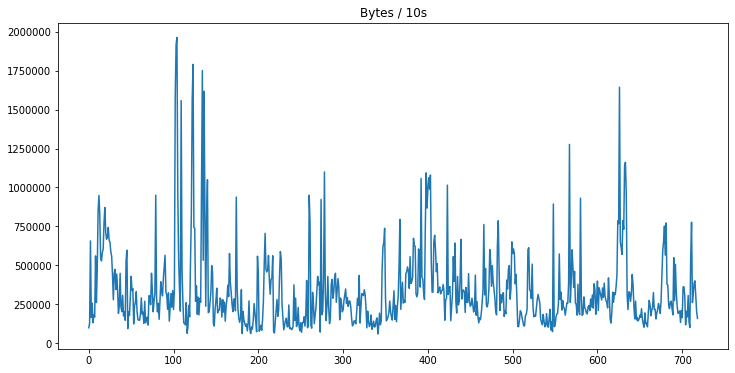

In [46]:
plt.figure(figsize=(12,6))
plt.plot(data_bytes['intervalle'], data_bytes['bytes'])
plt.title("Bytes / 10s")
plt.show()

# 2)

ARIMA (Auto Regressive Integrated Moving Average)

Dans cette question on vous propose de construire un modèle auto-régressif AR(p). L’apprentissage du modèle ne demande pas beaucoup de temps et s’effectue avec 1 − 2 lignes de code à l’aide de la fonction ARIMA() importée de statsmodels.tsa.arima_model. Le choix du paramètre p (d’une gamme de valeur prédéfinies, disons de 1 à p max ) est moins simple. On va aborder trois possibilité : critère d’information d’Akaike (AIC), critère d’information bayésien (BIC) et validation croisée/backtesting.

Le critères d’information AIC et BIC sont normalement implémentés dans le logiciel et sont donnés directement après l’apprentissage du modèle. Pour faire la validation croisée pour une série, on la coupe en n chunks chunks/folds et chaque fois utilise k premiers chunks pour entrainer le modèle et le chunk numéro k + 1 pour le tester (par exemple regarder le risque quadratique).

In [47]:
data_bytes = data_bytes.set_index('intervalle')

In [48]:
train_size = int(0.8*len(data_bytes))

In [49]:
arima = ARIMA(data_bytes.loc[:train_size], order=(15,0,0))
arima = arima.fit()

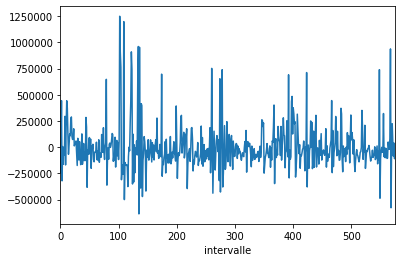

In [50]:
res = pd.DataFrame(arima.resid)
res.plot(legend=None)
plt.show()

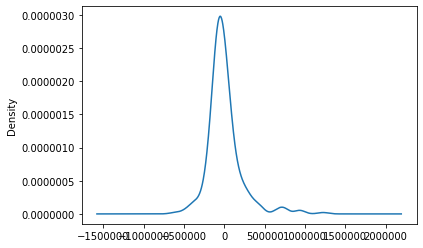

In [51]:
res.plot(kind='kde',legend=None)
plt.show()

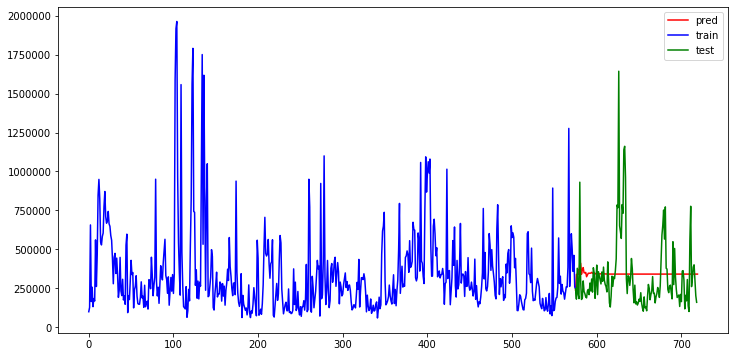

In [52]:
plt.figure(figsize=(12,6))
plt.plot(arima.predict(start=train_size, end=719),'r',label="pred")
plt.plot(data_bytes.loc[:train_size],'b', label="train")
plt.plot(data_bytes.loc[train_size:], 'g', label="test")
plt.legend()
plt.show()

On remarque que le modèle prédictif n'est pas très performant car il prédit une valeur constante au delà de t+1. En vérité l'AR n'est pas idéal pour prédire à des instants supérieurs à t+1.

In [53]:
nb_cross_val = 7

In [54]:
k = 0
mse_list = []
for i in range(1,nb_cross_val) :
    k = k + int(len(data_bytes)/nb_cross_val)
    model = ARIMA(data_bytes.loc[:k], order=(10,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(start=k, end=len(data_bytes))
    mse_list.append(mean_squared_error(pred, data_bytes.loc[k-1:]))

In [55]:
np.mean(mse_list)

52548331720.38486

L'erreur quadratique est très élevée et confirme que le modèle est peu performant.

# 10)
En se basant sur les résultats de la question précédente, sélectionnez l’ordre p du modèle AR à estimer et affichez les paramètres correspondants.

Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement. Commentez.

In [56]:
arima = ARIMA(data_bytes.loc[:500], order=(10,0,0))
arima = arima.fit()

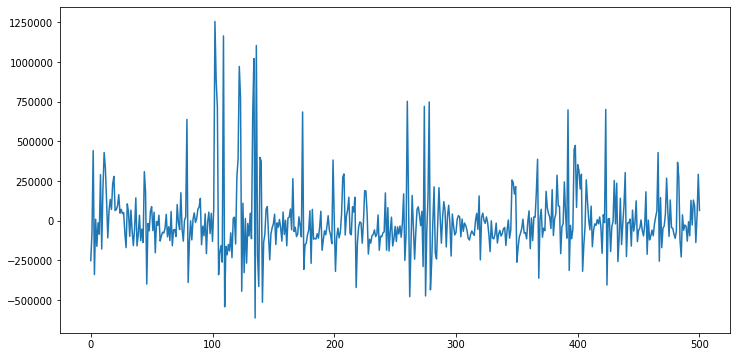

In [57]:
res = pd.DataFrame(arima.resid)
plt.figure(figsize=(12,6))
plt.plot(res)
plt.show()

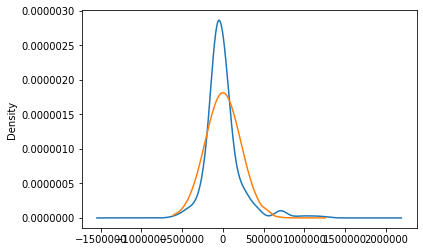

In [58]:
res_sorted = res.sort_values(0)
fit = stats.norm.pdf(res_sorted, np.mean(res_sorted), np.std(res_sorted))
res_sorted.plot(kind='kde',legend=None)
plt.plot(res_sorted,fit)
plt.show()

# Données “Southern oscillation index”

# 11)
Importez les données du fichier soi.tsv. Consultez http://www.bom.gov.au/climate/glossary/soi.shtml pour plus d’information sur les données. Supprimez les données manquantes.

In [59]:
data = pd.read_csv("soi.tsv", delimiter="\t", header=None).T.dropna()
data.head()

,0
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


# 12)
A l’aide des fonctions plot_acf() et plot_pacf() importées de statsmodels.graphics.tsaplots, tracez la fonction d’autocorrélation et la fonction d’autocorrélation partielle.

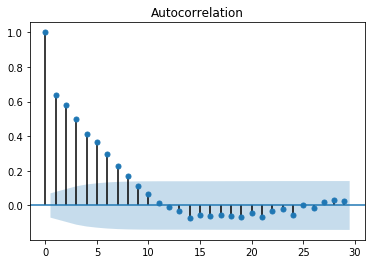

In [60]:
tsa.plot_acf(data);

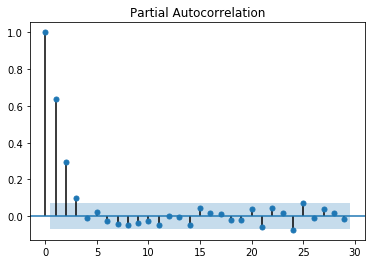

In [61]:
tsa.plot_pacf(data);

# 13)
En se basant sur la question précédente, choisissez l’ordre du processus auto-régressive AR(p). Entrainer le modèle AR choisi. Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement. Commentez.

In [62]:
model = ARMA(data, order=(15,0))
result = model.fit()

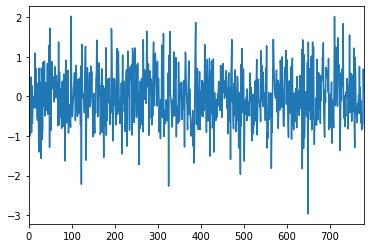

In [63]:
res = pd.DataFrame(result.resid)
res.plot(legend=None)
plt.show()

In [64]:
res_sorted = res.sort_values(0)
fit = stats.norm.pdf(res_sorted, np.mean(res_sorted), np.std(res_sorted))

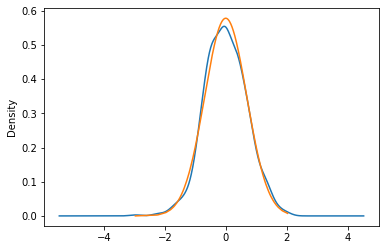

In [65]:
res.plot(kind='kde',legend=None)
plt.plot(res_sorted,fit)
plt.show()

# 14)
Tracez le périodogramme ; superposez le à la densité spectrale du modèle estimé à la question précédente. On utilisera qu’un modèle AR(p) de coefficients auto-régressifs φ 1 , . . . , φ p satisfaisant l’équation AR.

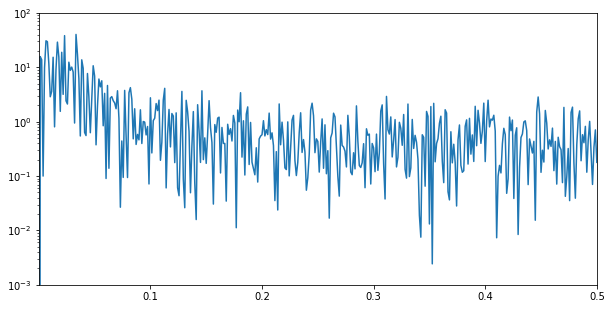

In [66]:
plt.figure(figsize=(10,5))
f, Pxx_den = signal.periodogram(data[0])
plt.semilogy(f, Pxx_den)
plt.xlim([1e-10, 0.5])
plt.ylim([1e-3, 1e+2])
plt.show()